### Convolutional Neural Network w/ Tensorflow

**Time Series Classification Example**

**Dataset:**  https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones


**Description:** 


- *The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.*


- *The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.*
____

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import os
from sklearn.model_selection import train_test_split

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [2]:
def get_data(split,seq_len):
    
    data_dir = 'data/UCI_HAR_Dataset'
    pth = os.path.join(data_dir, split)
    path_signals = os.path.join(pth, "Inertial_Signals")

    # Get Data
    channel_files = os.listdir(path_signals)  
    channel_files.sort()

    label_path = os.path.join(pth, "y_" + split + ".txt")
    labels = pd.read_csv(label_path, header = None)
    
    # Dimensions
    n_channels = len(channel_files)
    
    # Initialize Array (len_obs, sequence, channels)
    list_of_channels = []
    X = np.zeros((len(labels), seq_len, n_channels))

    idx = 0
    for file_ in channel_files:
        posix = len(split) + 5

        channel_name = file_.split('.')[0]        
        data = pd.read_csv(os.path.join(path_signals,file_), delim_whitespace = True,header = None).as_matrix()
        X[:,:,idx] = data
        
        # Record Names
        list_of_channels.append(channel_name)

        # iterate
        idx += 1
        
    #Standardize 
    X_std = standardize(X)
    
    return X_std, labels.iloc[:,0].values, list_of_channels


def standardize(X):
    
    """ Standardize data --> standardize column wise"""
    X_std = (X - np.mean(X, axis=0)[None,:,:]) / np.std(X, axis=0)[None,:,:]
    return X_std


def one_hot(labels):
    """ One-hot encoding """
    n_classes = len(np.unique(labels))
    encoder = np.eye(n_classes)[:,labels-1].T
    return encoder


def get_validation_set(X_train,y_train):
    
    X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, stratify = y_train, random_state = 42)
    return X_train, X_val, y_train, y_val
    
if __name__ == '__main__':
    
    seq_len = 128
   
    X_train, y_train, list_ch_train = get_data("train",seq_len) 
    X_test, y_test, list_ch_test = get_data("test",seq_len) 
    
    #Get X_Train and X_Validation Set
    X_train, X_val, y_train, y_val = get_validation_set(X_train,y_train)
    
    #Y Labels
    y_train,y_val,y_test = one_hot(y_train),one_hot(y_val),one_hot(y_test)

**Build Model**

In [3]:
class Convolutional_Nerual_Network():
    
    def __init__(self,params,batch_norm=False):
        
        # Argument to use toggle between implementing batch norm 
        # ToDo: Add Batch Normalization 
        self.batch_norm = batch_norm
        self.name = "Batch Normalization" if batch_norm else "Without Batch Normalization"

        # Batch normalization needs to do different calculations during training
        self.is_training = tf.placeholder(tf.bool, name= "is_training")

        # Store Accuracies
        self.training_accuracies = []
        self.testing_accuracies = []

        # Initialize Build
        self.build_network(**params)

    def conv1d_maxpool(self,X,filters,conv_ksize,conv_strides,pool_ksize,pool_strides):
        
        # Convolutional Layer
        conv = tf.layers.conv1d(X,filters=filters,kernel_size=conv_ksize,strides=conv_strides, padding='SAME',activation=tf.nn.relu) 
        max_pool = tf.layers.max_pooling1d(conv,pool_size=pool_ksize,strides=pool_strides,padding='SAME')
        return max_pool
    
    def build_network(self,**params):
        
        self.input = tf.placeholder(tf.float32, shape=[None,params['seq_length'],params['n_channels']], name='input')
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob') 
        
        # 1st Convolutional Layer
        conv1d_maxpool_layer_1 = self.conv1d_maxpool(self.input,params['filters_1'],
                                        params['conv_ksize'], params['conv_strides'],
                                        params['pool_ksize'], params['pool_strides'])

        # 2nd Convolutional Layer
        conv1d_maxpool_layer_2 = self.conv1d_maxpool(conv1d_maxpool_layer_1, params['filters_2'],
                                        params['conv_ksize'], params['conv_strides'],
                                        params['pool_ksize'], params['pool_strides'])
        
        # 3rd Convolutional Layer
        conv1d_maxpool_layer_3 = self.conv1d_maxpool(conv1d_maxpool_layer_2, params['filters_3'],
                                        params['conv_ksize'], params['conv_strides'],
                                        params['pool_ksize'], params['pool_strides'])
        
        # Fully Connected Layer
        flatten = tf.nn.dropout(tf.contrib.layers.flatten(conv1d_maxpool_layer_3),self.keep_prob)
        
        # Output Layer
        self.output_layer = tf.layers.dense(flatten, params['output_dim'])

        
    def train(self,X_train,X_val,y_train,y_val,session,learning_rate,batches,batches_per_sample,output_dim):
    
        # Target Labels
        labels = tf.placeholder(tf.float32,shape=[None,output_dim],name='labels')
    
        # Loss Function
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=self.output_layer))
                    
        # Define operations for testing validation set
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # Train
        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

        # Train model for the specified number of batches
        for i in tqdm.tqdm(range(batches)):
            
            # Random Mini-Batch Sample --> Training Set
            batch_x_train, batch_y_train = get_random_sample(X_train,y_train,batches_per_sample)
            batch_x_val, batch_y_val = get_random_sample(X_val,y_val,batches_per_sample)

            # Compute Loss on Training Set
            session.run(train_step,feed_dict={self.input: batch_x_train, 
                                             labels: batch_y_train,
                                             self.keep_prob: 0.50,self.is_training: False})
            
            # Periodically Get Accuracy Score for Random Sample from Validation Set
            if i % batches_per_sample == 0:
                self.training_accuracies.append(session.run(accuracy,feed_dict={self.input: batch_x_val,
                                                            labels: batch_y_val,self.keep_prob:0.50,
                                                            self.is_training: False}))
                      
        val_accuracy = session.run(accuracy,feed_dict={self.input: X_val, labels: y_val,
                                                       self.keep_prob: 0.50,
                                                       self.is_training: False})
        
        print('='*65)
        print('Average Validation Set Accuracy {0} = {1:.3f}%'.format(self.name, val_accuracy*100))
        
    def test(self,X_test,y_test,session,output_dim):

        # Placeholder will store target labels for each mini batch
        labels = tf.placeholder(tf.float32,shape=[None,output_dim],name='labels')

        # Define operations for testing
        correct_prediction = tf.equal(tf.argmax(self.output_layer, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # Test against all test data
        self.testing_accuracies.append(session.run(accuracy, feed_dict={self.input: X_test,
                                                         labels: y_test,
                                                         self.keep_prob:0.50,
                                                         self.is_training: False}))

        print('Average Test Set Accuracy {0} = {1:.3f}%'.format(self.name, np.mean(self.testing_accuracies)*100))
    

In [4]:
def get_random_sample(X,y,batch_sample):
    
    # Random Mini-Batch Sample
    rand_idx = np.random.choice(len(X),size=batch_sample)
    batch_x,batch_y = X[rand_idx],y[rand_idx]
    return batch_x, batch_y

def plot_accuracies(*args,**kwargs):
    
    """ Plot Validation Accuracy"""
    
    sample_size = kwargs['batch_sample_size']

    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111)
    colors = ['teal','orange','blue','coral']
    for idx,arg in enumerate(args):
        ax.plot(range(0,len(arg.training_accuracies)*sample_size,sample_size),
            arg.training_accuracies,lw=2.0,color=colors[idx],label=arg.name)
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0,1)
        ax.set_xlabel('Number of Batches')
        ax.legend(frameon=False,loc=(1.01,0.50))
        ax.set_title('Validation Accuracy Score',y=1.02)
    plt.grid(True)

def get_nn_parameters(seq_len,input_dim,n_channels,output_dim):

    params = {
            'input_dim':input_dim, # input dimensions
            'output_dim': output_dim, # output class labels
            'n_channels': n_channels, # number of dimensions
            'seq_length': seq_len, # sequence length of look-back window
            'filters_1':18, # number of filters (i.e. n_channels for first layer)
            'filters_2':36, # number of filters (i.e. n_channels for second layer)
            'filters_3': 72, # number of filters (i.e. n_channels for third layer)
            'conv_ksize': 2, # kernal size for conv.layer
            'conv_strides':1,
            'pool_ksize': 2, # kernal size for the conv. layer
            'pool_strides': 2, # stride for conv.
            }
    
    params['conv_strides'] = params['conv_ksize']/2, # stride for conv.
    params['conv_num_outputs'] = params['conv_ksize'] * params['conv_ksize'], # output dimension of conv. layer
    return params

def train_and_test(X_train,X_val,X_test,y_train,y_val,y_test,learning_rate,
                   n_batches,batch_size,*args):
    
    # Input Parameters
    params = get_nn_parameters(args[0],args[1],args[2],args[3])

    # Reset default graph if training two different models (i.e. with or w/out batch_norm)
    tf.reset_default_graph()

    # Create instance of Neural Network
    convnet = Convolutional_Nerual_Network(params)
    
    # Train Model
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
    
        # Training and Testing Model
        convnet.train(X_train,X_val,y_train,y_val,sess,learning_rate,n_batches,batch_size,params['output_dim'])
        convnet.test(X_test,y_test,sess,params['output_dim'])
    
    # Plot Results
    plot_accuracies(convnet,batch_sample_size=batch_sample_size)

100%|██████████| 10000/10000 [10:21<00:00, 16.09it/s]


Average Validation Set Accuracy Without Batch Normalization = 92.927%
Average Test Set Accuracy Without Batch Normalization = 86.563%
CPU times: user 35min 35s, sys: 6min, total: 41min 35s
Wall time: 10min 22s


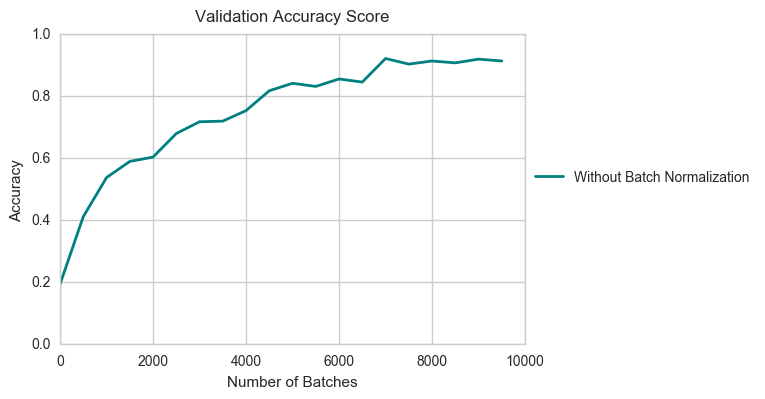

In [20]:
if __name__ == '__main__':
    
    learning_rate = 0.001
    n_batches = 10000
    batch_sample_size = 500
    
    n_classes = len(np.unique(np.argmax(np.concatenate([y_train,y_test],axis=0),axis=1)))
    %time results = train_and_test(X_train,X_val,X_test,y_train,y_val,y_test,learning_rate,n_batches,batch_sample_size,seq_len,len(X_train),X_train.shape[2],n_classes)